In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_curve, auc, precision_recall_curve
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline

from lightgbm import LGBMClassifier

import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv("C:\\Users\\user\\Downloads\\market classification project using TCN on interaday Gold data\\hourly features formula one.csv")
print(df)

      Unnamed: 0              date     open     high      low    close  \
0              0    4/22/2025 3:00  3471.10  3475.10  3466.80  3475.10   
1              1    4/22/2025 4:00  3472.57  3494.08  3472.28  3487.27   
2              2    4/22/2025 5:00  3487.55  3487.94  3479.20  3484.67   
3              3    4/22/2025 6:00  3484.95  3495.01  3474.14  3493.26   
4              4    4/22/2025 7:00  3492.59  3499.45  3477.36  3479.42   
...          ...               ...      ...      ...      ...      ...   
2937        2937  10/10/2025 11:00  3995.56  3999.84  3990.61  3993.68   
2938        2938  10/10/2025 12:00  3993.50  3999.70  3983.56  3986.96   
2939        2939  10/10/2025 13:00  3987.35  3993.31  3980.01  3985.40   
2940        2940  10/10/2025 14:00  3985.33  3997.99  3975.26  3978.33   
2941        2941  10/10/2025 15:00  3978.64  3993.93  3970.39  3989.12   

      volume  past_ret_1h  past_ret_2h  past_ret_4h  past_ret_8h  \
0         36    -0.046091    -0.046091    -

In [3]:
features = [
    "date","open","high","low","close","volume",
    "past_ret_1h","past_ret_2h","past_ret_4h","past_ret_8h","past_ret_16h",
    "probability","0.6 percent prediction","1 percent prediction",
    "1.5 percent prediction"
]

In [4]:
df["date"] = pd.to_datetime(df["date"]).map(pd.Timestamp.toordinal)
df = df.fillna(method="ffill").fillna(method="bfill")

C:\Users\user\AppData\Local\Temp\ipykernel_3088\4039671873.py:2: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method="ffill").fillna(method="bfill")


In [5]:
mapping = {"range": 0, "upward": 1, "downward": -1}
df["forward regime"] = df["forward regime"].map(mapping)

X = df[features]
y = df["forward regime"]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)


In [8]:
class_weights = {
    0: 1.511747430249633,
    1: 5.33419689119171,
    -1: 6.620578778135048
}

In [9]:
pipe = ImbPipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler", StandardScaler()),     # optional for LightGBM but helps with stability
    ("clf", LGBMClassifier(
        class_weight=class_weights,
        n_estimators=600,
        learning_rate=0.03,
        max_depth=-1,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multiclass",
        random_state=42
    ))
])

In [10]:
pipe.fit(X_train, y_train)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000115 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2708
[LightGBM] [Info] Number of data points in the train set: 2353, number of used features: 15
[LightGBM] [Info] Start training from score -1.097311
[LightGBM] [Info] Start training from score -1.099285
[LightGBM] [Info] Start training from score -1.099242


Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('clf',
                 LGBMClassifier(class_weight={-1: 6.620578778135048,
                                              0: 1.511747430249633,
                                              1: 5.33419689119171},
                                colsample_bytree=0.8, learning_rate=0.03,
                                n_estimators=600, objective='multiclass',
                                random_state=42, subsample=0.8))])

In [12]:
y_pred = pipe.predict(X_test)
print("\n--- Classification Report (LightGBM) ---\n")
print(classification_report(y_test, y_pred))


--- Classification Report (LightGBM) ---

              precision    recall  f1-score   support

          -1       0.59      0.30      0.40        89
           0       0.74      0.88      0.81       390
           1       0.63      0.44      0.52       110

    accuracy                           0.71       589
   macro avg       0.65      0.54      0.57       589
weighted avg       0.70      0.71      0.69       589



C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


C:\Users\user\AppData\Roaming\Python\Python311\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


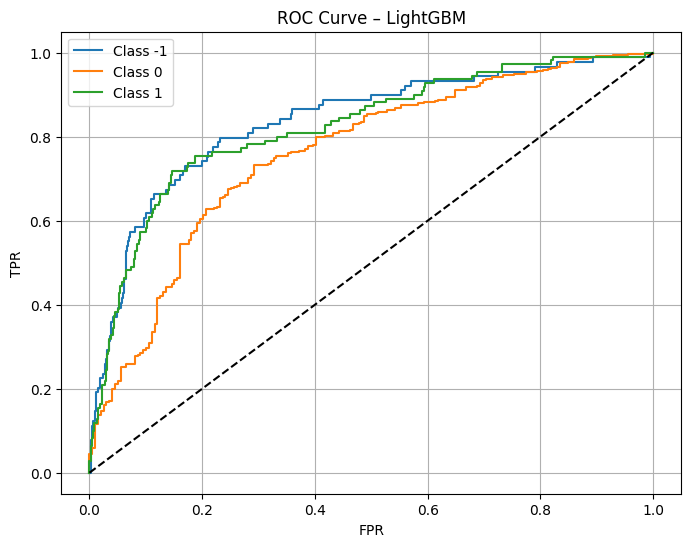

In [13]:
y_score = pipe.predict_proba(X_test)
classes = sorted(y.unique())

plt.figure(figsize=(8,6))
for i, c in enumerate(classes):
    fpr, tpr, _ = roc_curve((y_test == c).astype(int), y_score[:, i])
    plt.plot(fpr, tpr, label=f"Class {c}")
plt.plot([0,1], [0,1], 'k--')
plt.legend(); plt.title("ROC Curve – LightGBM")
plt.xlabel("FPR"); plt.ylabel("TPR")
plt.grid(True)
plt.show()

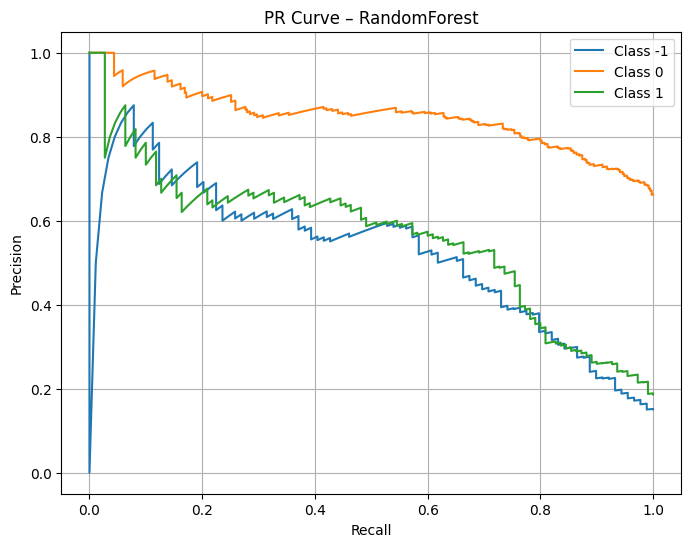

In [14]:
plt.figure(figsize=(8,6))
for i, c in enumerate(classes):
    prec, rec, _ = precision_recall_curve((y_test == c).astype(int), y_score[:, i])
    plt.plot(rec, prec, label=f"Class {c}")
plt.legend(); plt.title("PR Curve – RandomForest")
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.grid(True)
plt.show()


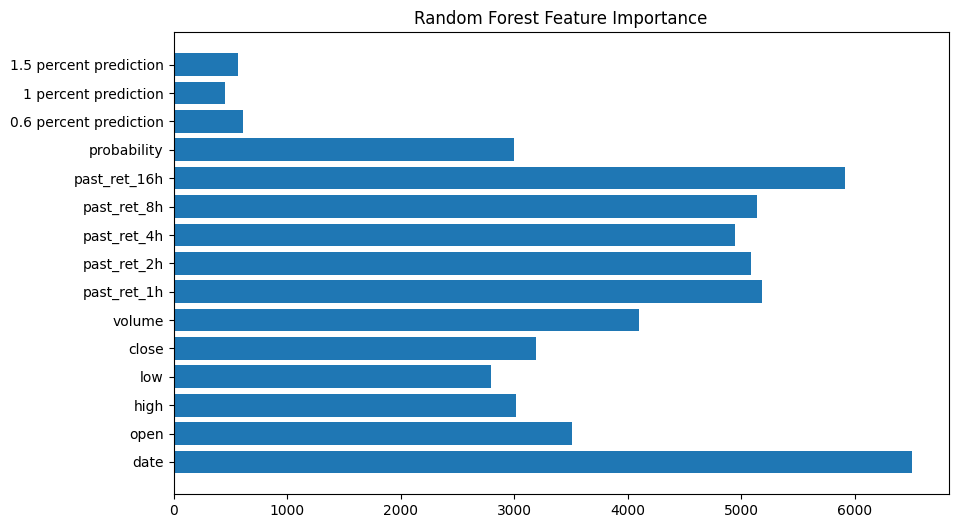

In [15]:
clf = pipe.named_steps["clf"]
importances = clf.feature_importances_

plt.figure(figsize=(10,6))
plt.barh(features, importances)
plt.title("Random Forest Feature Importance")
plt.show()